# Fun exercises on Spark using the Movielens Dataset

We are going to use the [MovieLens](https://grouplens.org/datasets/movielens/) dataset for these exercises. This is non trivial and should expand to about 1GB on you hard-drive.

Download and unzip [MovieLens 25M Dataset](https://grouplens.org/datasets/movielens/25m/) for this analysis.

Either ensure the data is in ```"./data/ml-25m"``` folder or update the path to the data below.

**Citation**:  
*F. Maxwell Harper and Joseph A. Konstan.* 2015.  
The MovieLens Datasets: History and Context.  
ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19. <https://doi.org/10.1145/2827872>  

You got this.  


In [1]:
# Step 1: initialize findspark
import findspark
findspark.init()

In [2]:
# Step 2: import pyspark
import pyspark
from pyspark.sql import SparkSession
pyspark.__version__

'3.3.0'

In [3]:
# Step 3: Create a spark session

# using local[*] to use as many logical cores as available, use 1 when in doubt
# 'local[1]' indicates spark on 1 core on the local machine or specify the number of cores needed
# use .config("spark.some.config.option", "some-value") for additional configuration

spark = SparkSession \
    .builder \
    .master('local[*]') \
    .appName("Analyzing Movielens Data") \
    .getOrCreate()

# spark

# ...to read and load the data *correctly*

This is typically the first problem you need to work out. You'll see.  
  
If you've downloaded and unzipped the data, you'll see that some of the files are quite large (genome-scores.csv is 400+ Mb, ratings.csv is 600+ Mb).  

So before we start loading the data to explore further, let's go through the [readme](https://files.grouplens.org/datasets/movielens/ml-25m-README.html) file to build a strategy for loading and analyzing data without clogging up the system.  

In real life, either you'll have to load files in small chunks to work out a strategy or you'll have to rely on defined schema for data.  

Here's the list of files (as of Aug 2022) that you get when you unzip the dataset:
1. **movies**.csv - list of movies with at least one rating.  
    Header: ```movieId,title,genres```  
1. **links**.csv - IDs to generate links to the movie listing on imdb.com and themoviedb.org  
    Header: ```movieId,imdbId,tmdbId```  
1. **ratings**.csv - Each line of this file after the header row represents one rating of one movie by one user.  
    Header: ```userId,movieId,rating,timestamp```  
1. **tags**.csv - Each line of this file after the header row represents one tag applied to one movie by one user.  
    Header: ```userId,movieId,tag,timestamp```  
1. Tag Genome: The tag genome contains tag relevance scores for movies. See [this](http://files.grouplens.org/papers/tag_genome.pdf)  
	1. **genome-tags**.csv - A list of tags  
    Header: ```tagId,tag```  
	1. **genome-scores**.csv - Each movie in the genome has a relevance score value for every tag in the genome  
    Header: ```movieId,tagId,relevance```  
1. README.txt - Check out the README.txt for more details about the files.  

## formatting and encoding

From the Readme file, we have the following observations about the data:
1. Each file is a CSV with a single header row
1. Separator char is ```,```
1. Escape char is ```"```
1. Encoding is UTF-8

Let's set these options when reading the CSV files.

In [4]:
from pyspark.sql.types import *
# where possible, let's avoid inferSchema
# 
schema_movies = StructType([
    StructField('movieId', StringType(), False),
    StructField('title', StringType(), False),
    StructField('genres', StringType(), True)    
    ])
# 
schema_ratings = StructType([
    StructField('userId', StringType(), False),
    StructField('movieId', StringType(), False),
    StructField('rating', IntegerType(), True),
    StructField('timestamp', StringType(), True)
    ])
# 
schema_tags = StructType([
    StructField('userId', StringType(), False),
    StructField('movieId', StringType(), False),
    StructField('tag', StringType(), True),
    StructField('timestamp', StringType(), True)
    ])
# 
schema_genome_tags = StructType([
    StructField('tagId', StringType(), False),
    StructField('tag', StringType(), False)
    ])
# 
# using arbitrary precision signed decimals (java.math.BigDecimal) for relevance scores
schema_genome_scores = StructType([
    StructField('movieId', StringType(), False),
    StructField('tagId', StringType(), False),
    StructField('relevance', DecimalType(), False)
    ])

In [5]:
datalocation = "./data/ml-25m/"
movies_file = datalocation + 'movies.csv'
ratings_file = datalocation + 'ratings.csv'
tags_file = datalocation + 'tags.csv'
genome_tags_file = datalocation + 'genome-tags.csv'
genome_scores_file = datalocation + 'genome-scores.csv'

In [6]:
movies_raw = spark.read.format('csv') \
    .option('encoding', 'UTF-8') \
    .option('header', True) \
    .option('sep', ',') \
    .option('escape','\"') \
    .schema(schema_movies) \
    .load(movies_file)

In [7]:
movies_raw.show(10,False)

+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
|6      |Heat (1995)                       |Action|Crime|Thriller                      |
|7      |Sabrina (1995)                    |Comedy|Romance                             |
|8      |Tom and Huck (1995)               |Adventure|Children                         |
|9      |Sudden Death

In [8]:
ratings_raw = spark.read.format('csv') \
    .option('encoding', 'UTF-8') \
    .option('header', True) \
    .option('sep', ',') \
    .option('escape','\"') \
    .schema(schema_ratings) \
    .load(ratings_file)

In [9]:
ratings_raw.show(10, False)

+------+-------+------+----------+
|userId|movieId|rating|timestamp |
+------+-------+------+----------+
|1     |296    |null  |1147880044|
|1     |306    |null  |1147868817|
|1     |307    |null  |1147868828|
|1     |665    |null  |1147878820|
|1     |899    |null  |1147868510|
|1     |1088   |null  |1147868495|
|1     |1175   |null  |1147868826|
|1     |1217   |null  |1147878326|
|1     |1237   |null  |1147868839|
|1     |1250   |null  |1147868414|
+------+-------+------+----------+
only showing top 10 rows



In [10]:
tags_raw = spark.read.format('csv') \
    .option('encoding', 'UTF-8') \
    .option('header', True) \
    .option('sep', ',') \
    .option('escape','\"') \
    .schema(schema_tags) \
    .load(tags_file)

In [11]:
tags_raw.show(10, False)

+------+-------+-----------------------+----------+
|userId|movieId|tag                    |timestamp |
+------+-------+-----------------------+----------+
|3     |260    |classic                |1439472355|
|3     |260    |sci-fi                 |1439472256|
|4     |1732   |dark comedy            |1573943598|
|4     |1732   |great dialogue         |1573943604|
|4     |7569   |so bad it's good       |1573943455|
|4     |44665  |unreliable narrators   |1573943619|
|4     |115569 |tense                  |1573943077|
|4     |115713 |artificial intelligence|1573942979|
|4     |115713 |philosophical          |1573943033|
|4     |115713 |tense                  |1573943042|
+------+-------+-----------------------+----------+
only showing top 10 rows



Let's load the other files later.

Here's the exercises we'll do with this data next

# Problem Set 1  - ```tags.csv```

1. Some tags may have wrapping quotation marks or similar special characters, also leading/trailing spaces etc. Cleanup tags
    * for example, the tag ```"A Christmas Carol"``` becomes ```A Christmas Carol``` etc.

1. List all unique tags found in ```tags.csv```  
    * sort all tags lexically 
    * Also print the execution plan  
    * *[think]* If there are multiple ways of doing this, compare the execution plans  
  
1. Which movies have the most number of tags? 
    * List movieIds in order of # of tags associated  
    * Can we find out which movies have most # of *distinct* tags?
    * Does the ```timestamp``` column have any impact on your report?

1. Which users have added the most number of tags?
    * List userIds in order of # of tags created  
    * Can we find out which users have created most # of *distinct* tags?
    * Does the ```timestamp``` column have any impact on your report?

1. Which users have tagged the most number of movies?
    * Like before, can we find out which users have tagged the most # of *distinct* movies? Does this question make sense in the context of users?
    * Does the ```timestamp``` column have any impact on your report?

1. *[optional, skip on first attept]* We want to find out if there were days of higher activity during the tagging exercise or if the tagging output was more-or-less consistent. 
    * Convert time-stamps to Day-Month-Year. 
    * Find the date range (min-date, max-date) during which the tagging activity took place.
    * Plot number of movies tagged per day during the date range

1. *[optional, skip on first attept]* We want to find out how many users were active every day of the tagging activity. 
    * Plot number of users who tagged at least one movie during the tagging activity date range

## Solutions to Problem Set 1

### Cleanup  
Some tags may have wrapping quotation marks or similar special characters, also leading/trailing spaces etc. Cleanup tags  

* for example, the tag "A Christmas Carol" becomes A Christmas Carol etc.

In [12]:
# Remove wrapping quotation marks from tags

# if there's cleanup needed, 
# we do that first before finding out unique records, 
# chances are uniqueness will be affected if we don't follow this order.

from pyspark.sql.functions import col, lower, regexp_replace, trim

In [13]:
# define a regex pattern to use. 
# ^ indicates start of string, $ indicates end of string
# double quote or single quote or ampersand or bang just after start of string
pattern_start = '^\"|^\'|^&|^#'
# double quote or single quote or ampersand or bang just before end of string
pattern_end =  '\"$|\'$|&$|#$'
pattern = pattern_start+'|'+pattern_end

In [14]:
# create a new tags dataframe with cleaned up data 
tags = tags_raw.withColumn('tag', regexp_replace(trim(col('tag')), pattern, ''))

In [15]:
# quotes stripped and other chars too...
tags_raw.filter(col('tag').contains('Christmas Carol')).show()
tags.filter(col('tag').contains('Christmas Carol')).show()

+------+-------+-------------------+----------+
|userId|movieId|                tag| timestamp|
+------+-------+-------------------+----------+
| 63844|   4023|"A Christmas Carol"|1457037403|
+------+-------+-------------------+----------+

+------+-------+-----------------+----------+
|userId|movieId|              tag| timestamp|
+------+-------+-----------------+----------+
| 63844|   4023|A Christmas Carol|1457037403|
+------+-------+-----------------+----------+



### List all unique tags found in ```tags.csv```  
    * sort all tags lexically 
    * Also print the execution plan  
    * *[think]* If there are multiple ways of doing this, compare the execution plans  

In [16]:
# unique tags found in tags.csv - prep
# careful - comparision should be case-insensitive 
# because 'Christmas Special' and 'Christmas special' are really the same thing
# create a new column in tags
tags = tags.withColumn('lower tag', lower(col('tag')))
# reorder columns for easy readability
tags = tags.select('userId', 'movieId', 'tag', 'lower tag', 'timestamp')
tags.show(5,False)

+------+-------+----------------+----------------+----------+
|userId|movieId|tag             |lower tag       |timestamp |
+------+-------+----------------+----------------+----------+
|3     |260    |classic         |classic         |1439472355|
|3     |260    |sci-fi          |sci-fi          |1439472256|
|4     |1732   |dark comedy     |dark comedy     |1573943598|
|4     |1732   |great dialogue  |great dialogue  |1573943604|
|4     |7569   |so bad it's good|so bad it's good|1573943455|
+------+-------+----------------+----------------+----------+
only showing top 5 rows



In [17]:
# unique tags found in tags.csv - method 1, using distinct()
distinct_tags1 = tags.select('lower tag').distinct()
# 
# let's do the explaining later, so it's easy to compare methods
# distinct_tags.explain(True)
# show 5 rows, do not truncate
distinct_tags1.show(5, False)

+-------------+
|lower tag    |
+-------------+
|anime        |
|art          |
|traveling    |
|travel       |
|loss of child|
+-------------+
only showing top 5 rows



In [18]:
# unique tags found in tags.csv - method 2, using groupBy()
# an aggregator like count() results in a dataframe
# distinct_tags2 = tags.select('lower tag').groupBy('lower tag').count()
distinct_tags2 = tags.select('lower tag').groupBy('lower tag').count()
# let's do the explaining later, so it's easy to compare methods
# distinct_tags2.explain(True)
# show 5 rows, no truncate
distinct_tags2.show(5,False)

+-------------+-----+
|lower tag    |count|
+-------------+-----+
|anime        |1585 |
|art          |340  |
|traveling    |14   |
|travel       |256  |
|loss of child|21   |
+-------------+-----+
only showing top 5 rows



Execution plan explanations to compare distinct() and groupBy()...  
(uncomment the lines below)

In [19]:
# distinct_tags1.explain(True)

In [20]:
# distinct_tags2.explain(True)

Compare the costs in the two execution plans

In [21]:
# distinct_tags1.explain(mode='cost')

In [22]:
# distinct_tags2.explain(mode='cost')

The two plans look identical:

**distinct()**  
  
```
== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Sort [lower tag#130 ASC NULLS FIRST], true, 0
   +- Exchange rangepartitioning(lower tag#130 ASC NULLS FIRST, 200), ENSURE_REQUIREMENTS, [id=#1415]
      +- HashAggregate(keys=[lower tag#130], functions=[], output=[lower tag#130])
         +- Exchange hashpartitioning(lower tag#130, 200), ENSURE_REQUIREMENTS, [id=#1412]
            +- HashAggregate(keys=[lower tag#130], functions=[], output=[lower tag#130])
               +- Project [lower(regexp_replace(trim(tag#55, None), ^"|^'|^&|^#|"$|'$|&$|#$, , 1)) AS lower tag#130]
                  +- FileScan csv [tag#55] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/.../tags.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<tag:string>
```

**groupBy()**  
  
```
== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Sort [lower tag#130 ASC NULLS FIRST], true, 0
   +- Exchange rangepartitioning(lower tag#130 ASC NULLS FIRST, 200), ENSURE_REQUIREMENTS, [id=#1437]
      +- HashAggregate(keys=[lower tag#130], functions=[count(1)], output=[lower tag#130, count#176L])
         +- Exchange hashpartitioning(lower tag#130, 200), ENSURE_REQUIREMENTS, [id=#1434]
            +- HashAggregate(keys=[lower tag#130], functions=[partial_count(1)], output=[lower tag#130, count#186L])
               +- Project [lower(regexp_replace(trim(tag#55, None), ^"|^'|^&|^#|"$|'$|&$|#$, , 1)) AS lower tag#130]
                  +- FileScan csv [tag#55] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/.../tags.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<tag:string>
```


Spark optimizes both to identical plans / Inner workings for both seem identical in the optimized execution plan.  

So we tend to prefer the one that is easier to read when debugging the code.  

There may be a need for both distinct() and groupBy() in the same piece of code - for readability. We'll see that a few sections later.  

*In some cases, I saw (and I am probably wrong here) that the groupBy() method seems marginally more expensive in terms of memory as compared to distinct(). Log a comment/ticket/PR if you have evidence, insights, ideas to the contrary/in-support.*

#### Sort lexically

In [23]:
# sort unique tags lexically
# ignore case when sorting values 
distinct_tags1 = distinct_tags1.orderBy(col('lower tag').asc())
distinct_tags2 = distinct_tags2.orderBy(col('lower tag').asc())

In [24]:
distinct_tags1.filter(col('lower tag').contains('christmas')).show(50, False)

+-----------------------------------------------------------+
|lower tag                                                  |
+-----------------------------------------------------------+
|a christmas carol                                          |
|anti christmas                                             |
|best christmas movie                                       |
|christmas                                                  |
|christmas bonus                                            |
|christmas card                                             |
|christmas carol                                            |
|christmas england history                                  |
|christmas eve                                              |
|christmas gift                                             |
|christmas holiday                                          |
|christmas horror                                           |
|christmas lights                                           |
|christm

In [25]:
distinct_tags2.filter(col('lower tag').contains('christmas')).show(50, False)

+-----------------------------------------------------------+-----+
|lower tag                                                  |count|
+-----------------------------------------------------------+-----+
|a christmas carol                                          |1    |
|anti christmas                                             |1    |
|best christmas movie                                       |7    |
|christmas                                                  |1162 |
|christmas bonus                                            |1    |
|christmas card                                             |2    |
|christmas carol                                            |11   |
|christmas england history                                  |1    |
|christmas eve                                              |36   |
|christmas gift                                             |5    |
|christmas holiday                                          |4    |
|christmas horror                               

### Which movies have the most number of tags?  
* List movieIds in order of # of tags associated  
* Can we find out which movies have most # of *distinct* tags?  
* *[optional]* Does the ```timestamp``` column have any impact on your report?  

In [26]:
# movie IDs with most number of tags
movies_by_tag_count = tags.groupBy('movieId').count()
movies_by_tag_count.orderBy(col('count').desc()).show()

+-------+-----+
|movieId|count|
+-------+-----+
|    260| 6180|
|  79132| 4767|
|    296| 4767|
| 109487| 3616|
|   2959| 3612|
|    318| 3597|
|   2571| 3573|
|    356| 2701|
|   4226| 2601|
|   7361| 2533|
|    593| 2482|
|   4878| 2417|
|   4973| 2226|
|  48780| 2126|
| 115713| 2115|
|  72998| 2105|
|    541| 2081|
|  58559| 1956|
|     47| 1947|
|   2858| 1904|
+-------+-----+
only showing top 20 rows



These movies have thousands of tags??? that makes no sense... let's see what some of those are:

In [27]:
tags.filter(col('movieId') == 260) \
    .groupBy(lower(col('tag')).alias('lowercase tag')) \
    .count() \
    .orderBy(col('count').desc()) \
    .show(25, False)

+---------------+-----+
|lowercase tag  |count|
+---------------+-----+
|sci-fi         |658  |
|space          |302  |
|classic        |273  |
|science fiction|270  |
|space adventure|263  |
|classic sci-fi |232  |
|action         |178  |
|adventure      |160  |
|fantasy        |150  |
|star wars      |143  |
|space opera    |139  |
|harrison ford  |117  |
|good vs evil   |115  |
|epic           |112  |
|space action   |104  |
|space epic     |84   |
|cult classic   |76   |
|george lucas   |71   |
|epic adventure |55   |
|jedi           |55   |
|scifi          |54   |
|aliens         |53   |
|futuristic     |51   |
|scifi cult     |46   |
|hero's journey |45   |
+---------------+-----+
only showing top 25 rows



Any guesses what this movie could be?

In [28]:
movies_raw.filter(col('movieId') == 260).show(1, False)

+-------+-----------------------------------------+-----------------------+
|movieId|title                                    |genres                 |
+-------+-----------------------------------------+-----------------------+
|260    |Star Wars: Episode IV - A New Hope (1977)|Action|Adventure|Sci-Fi|
+-------+-----------------------------------------+-----------------------+



No surprises there!

### Which users have added the most number of tags?

* List ```userIds``` in order of # of tags created
* Can we find out which users have created most # of distinct tags?

In [29]:
# users who have created most tags
users_by_count_of_tag_entries = tags.groupBy('userId').count()
users_by_count_of_tag_entries.orderBy(col('count').desc()).show()

+------+------+
|userId| count|
+------+------+
|  6550|183356|
| 21096| 20317|
| 62199| 13700|
|160540| 12076|
|155146| 11445|
| 70092| 10582|
|131347| 10195|
| 14116| 10167|
| 31047|  8463|
|141263|  7114|
| 64333|  6944|
| 47969|  6599|
| 15204|  6426|
| 84824|  6209|
|123527|  6005|
|148457|  5960|
| 19346|  5919|
|  6285|  5837|
| 96795|  5334|
| 44444|  4941|
+------+------+
only showing top 20 rows



Can we find out which users have created most # of distinct tags?

In [30]:
# isolate userId and tags and identify distinct pairs
distinct_tags_by_user = tags.select('userId', 'tag').distinct()
# count distinct tags by user
count_distinct_tags_by_user = distinct_tags_by_user.groupBy('userId').count()
# list count of distinct tags by user
count_distinct_tags_by_user.orderBy(col('count').desc()).show()

+------+-----+
|userId|count|
+------+-----+
|  6550|20765|
| 31047| 5574|
|155146| 5252|
| 62199| 4959|
|131347| 4834|
|160540| 4783|
|148457| 3550|
| 47969| 3042|
| 14116| 2913|
|141263| 2837|
| 19346| 2808|
| 96795| 2304|
| 64333| 2268|
| 15204| 2190|
| 44444| 2156|
|105728| 2150|
|123527| 2131|
| 34047| 2103|
| 56238| 2018|
| 83426| 1942|
+------+-----+
only showing top 20 rows



*Holy Sith!* 

*183356* tags, *20765* unique tags - UserId ```6550``` is either a beast or probably a bot!  

In most cases we may want to treat this one as an outlier, further analysis may be needed before taking that decision, but it's good to know 6550 exists.  

In [31]:
distinct_tags_by_user.filter(col('userId') =='6550').orderBy(col('tag')).show(50, False)

+------+---------------+
|userId|tag            |
+------+---------------+
|6550  |007            |
|6550  |077            |
|6550  |10th century   |
|6550  |11th century   |
|6550  |12th century   |
|6550  |13th century   |
|6550  |14th century   |
|6550  |15th century   |
|6550  |16th century   |
|6550  |17th century   |
|6550  |1860s          |
|6550  |18th century   |
|6550  |1910s          |
|6550  |1920s          |
|6550  |1930s          |
|6550  |1940s          |
|6550  |1950s          |
|6550  |1960s          |
|6550  |1970s          |
|6550  |1980s          |
|6550  |1990s          |
|6550  |19th century   |
|6550  |1st century    |
|6550  |2040s          |
|6550  |20th century   |
|6550  |21st century   |
|6550  |25th century   |
|6550  |2nd century    |
|6550  |3 dimensional  |
|6550  |360 video      |
|6550  |3d             |
|6550  |47 ronin       |
|6550  |80's           |
|6550  |80's style     |
|6550  |Afghanistan    |
|6550  |Africa         |
|6550  |Agent Coulson  |


Yeah! I'd say 6550 is some automated tagging mechanism. 

### Which users have tagged the most number of movies?
* Like before, can we find out which users have tagged the most # of *distinct* movies? Does this question make sense in the context of users?
* *[optional]* Does the ```timestamp``` column have any impact on your report?

In [32]:
# which users have tagged the most number of movies?

# approach:
# create a df that has only users and movies
# this df may have multiple rows for 
# same userId and movieId as each user has given many tags to each movie 
# so only pick distinct records.
# then use groupBy and count as ususal

users_and_movies_in_tags = tags.select('userId', 'movieId').distinct()

users_and_movies_in_tags_count = users_and_movies_in_tags.groupBy('userId') \
    .count() \
    .orderBy(col('count').desc())

users_and_movies_in_tags_count.show(10)

+------+-----+
|userId|count|
+------+-----+
|  6550|37913|
| 62199|10840|
| 21096| 7547|
| 70092| 7171|
| 64333| 2615|
| 14116| 2361|
| 72360| 2073|
|125054| 1712|
|131347| 1602|
| 34164| 1526|
+------+-----+
only showing top 10 rows



In [33]:
# check: 
# filter for any one userId, check that all movies occur only once
users_and_movies_in_tags.filter(col('userId') == 6550) \
    .groupBy('movieId').count() \
    .orderBy(col('count').desc()) \
    .show(10)

+-------+-----+
|movieId|count|
+-------+-----+
|   2069|    1|
|  85022|    1|
|   3959|    1|
| 119655|    1|
|  26112|    1|
|  60336|    1|
|   1436|    1|
|   3210|    1|
|   2904|    1|
|  35640|    1|
+-------+-----+
only showing top 10 rows



### Tagging activity related analysis

* Convert time-stamps to Day-Month-Year.
* Find the date range (min-date, max-date) during which the tagging activity took place.
* Plot number of movies tagged per day during the date range

In [34]:
from pyspark.sql.functions import from_unixtime, to_date

# convert unix epoch timestamp to date-time style timestamp
tags = tags.withColumn('datetime', from_unixtime(col('timestamp')))
# extract date from date-time timestamp
tags = tags.withColumn('tagging date', to_date(col('datetime')))
tags.show(10, False)

+------+-------+-----------------------+-----------------------+----------+-------------------+------------+
|userId|movieId|tag                    |lower tag              |timestamp |datetime           |tagging date|
+------+-------+-----------------------+-----------------------+----------+-------------------+------------+
|3     |260    |classic                |classic                |1439472355|2015-08-13 18:55:55|2015-08-13  |
|3     |260    |sci-fi                 |sci-fi                 |1439472256|2015-08-13 18:54:16|2015-08-13  |
|4     |1732   |dark comedy            |dark comedy            |1573943598|2019-11-17 04:03:18|2019-11-17  |
|4     |1732   |great dialogue         |great dialogue         |1573943604|2019-11-17 04:03:24|2019-11-17  |
|4     |7569   |so bad it's good       |so bad it's good       |1573943455|2019-11-17 04:00:55|2019-11-17  |
|4     |44665  |unreliable narrators   |unreliable narrators   |1573943619|2019-11-17 04:03:39|2019-11-17  |
|4     |115569 |ten

In [35]:
tagging_activity_by_date = tags.groupBy(col('tagging date')).count()
# 
tagging_activity_by_date.orderBy(col('count').desc()).show(5, False)

+------------+-----+
|tagging date|count|
+------------+-----+
|2018-06-10  |26871|
|2018-05-27  |26644|
|2018-05-28  |21775|
|2018-05-18  |20808|
|2018-05-25  |18488|
+------------+-----+
only showing top 5 rows



#### date range during which the tagging activity took place

* (min-date, max-date) 

In [36]:
from pyspark.sql.functions import min, max
# 
tagging_min_date = tagging_activity_by_date.select(min(col('tagging date')))
tagging_max_date = tagging_activity_by_date.select(max(col('tagging date')))
# 
tagging_min_date.show()
tagging_max_date.show()

+-----------------+
|min(tagging date)|
+-----------------+
|       2005-12-24|
+-----------------+

+-----------------+
|max(tagging date)|
+-----------------+
|       2019-11-21|
+-----------------+



In [37]:
# setup matplotlib before starting plotting
import matplotlib.pyplot as plt
# jupyter mpl magic
%matplotlib inline

# note: in case you want to use the widget or notebook magic:
# ensure that ipympl is also installed.
# there may be other steps involved as well 
# for e.g. widget works based on nodeJS, so you'll have to config/enable that too

In [38]:
# determine the X and Y lists for plotting.
# converting a spark dataframe column to list:
tagging_activity_x = tagging_activity_by_date \
                        .select(col('tagging date')) \
                        .rdd \
                        .flatMap(lambda x: x) \
                        .collect()

tagging_activity_y = tagging_activity_by_date \
                        .select(col('count')) \
                        .rdd \
                        .flatMap(lambda x: x) \
                        .collect()

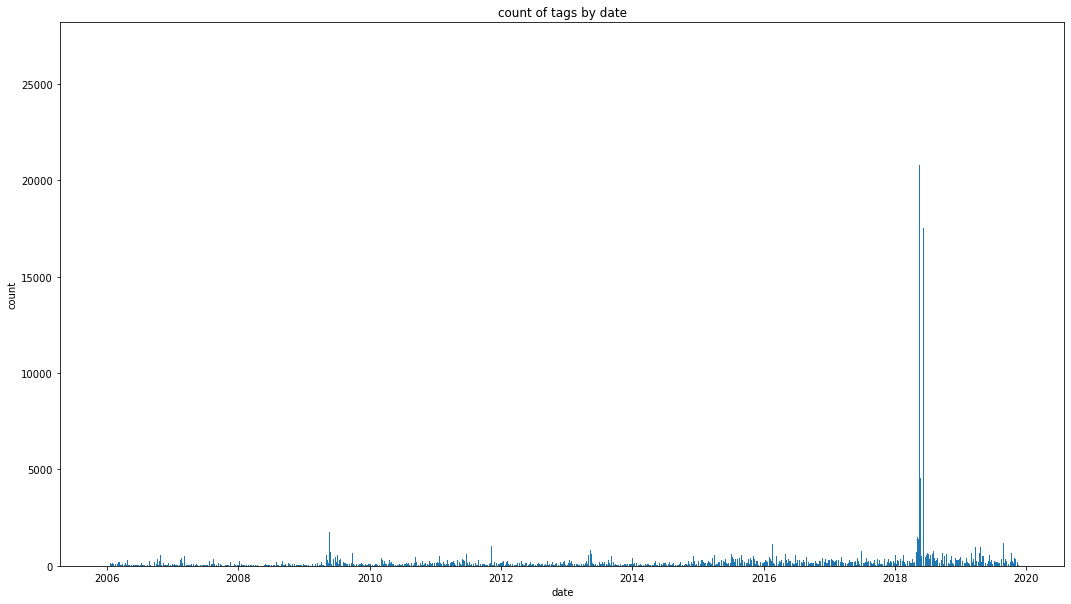

In [39]:
plt.figure(figsize=(18,10))
plt.bar(tagging_activity_x,tagging_activity_y)
plt.title('count of tags by date')
plt.xlabel('date')
plt.ylabel('count')
plt.show()

Seems like the activity peaked extraordinarily around May/June 2018

### Daily active users during the tagging activity.

* Plot number of users who tagged at least one movie during the tagging activity date range

In [40]:
distinct_users_doing_tagging_by_date = tags.select('userId', 'tagging date') \
    .distinct() \
    .groupBy('tagging date') \
    .count()
# 
distinct_users_doing_tagging_by_date.orderBy(col('count').desc()).show(5)

+------------+-----+
|tagging date|count|
+------------+-----+
|  2015-08-17|  180|
|  2018-05-06|   87|
|  2018-05-05|   78|
|  2018-05-07|   71|
|  2015-07-27|   64|
+------------+-----+
only showing top 5 rows



In [41]:
# like before, we need to determine X and Y lists.

distinct_users_doing_tagging_by_date_x = distinct_users_doing_tagging_by_date \
                                        .select(col('tagging date')) \
                                        .rdd \
                                        .flatMap(lambda x: x) \
                                        .collect()

distinct_users_doing_tagging_by_date_y = distinct_users_doing_tagging_by_date \
                                        .select(col('count')) \
                                        .rdd \
                                        .flatMap(lambda x: x) \
                                        .collect()

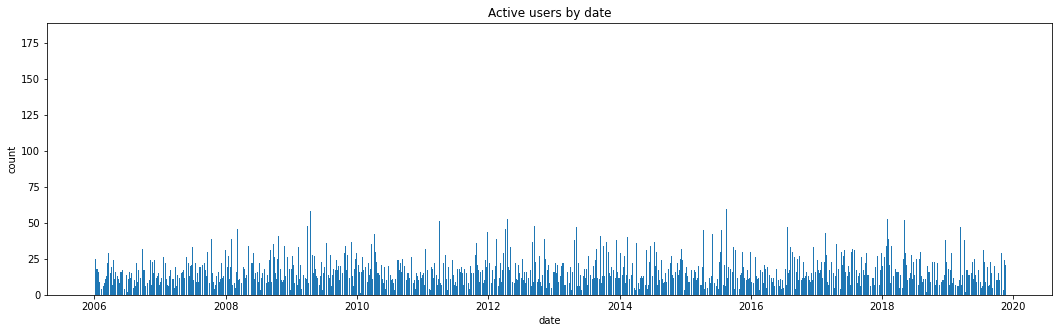

In [42]:
plt.figure(figsize=(18,5))
plt.bar(distinct_users_doing_tagging_by_date_x,distinct_users_doing_tagging_by_date_y)
plt.title('Active users by date')
plt.xlabel('date')
plt.ylabel('count')
plt.show()

Seems like while there were peaks and troughs, but visually, we don't see too much variation in the daily active users

# Problem Set 2  - ```movies.csv```

1. How many unique movies exist in the ```movies.csv``` dataset?  

1. Extract the year of release in movies.csv into a new column year_of_release  

1. Prepare a yearwise list of movies - list all the movies released in 1995, then 1996 and so on...   

1. List all unique genres found in ```movies.csv```, ordered lexically, case insensitive  

1. Prepare a genere wise list of movies - list all the movies for 'Crime', for 'Romance', and so on...

1. Add another column num_genres and list total number of genres associated with each film  

1. Find number of films associated with each genre - absolute_frequency_of_genre  

1. Find out if a movie has both genres associated with it and also has ```(no genres listed)``` - if this is the case, find out how many such movies exist in the data set

*[think]*: Is there a 'variety' metric? sum of absolute frequencies divided by total absolute frequency?


## Solutions to Problem Set 2

### How many unique movies exist in the movies.csv dataset?

In [43]:
from pyspark.sql.functions import explode
from pyspark.sql.functions import split

In [44]:
# unique genres found in movies.csv
movie_genres = movies_raw.select(
    explode( # convert each element in an array to a new row
        split( # split the data on pipe and create an arry
            movies_raw.genres, "\|"
        )
    ).alias('genre')
)

In [45]:
genre_freq = movie_genres.groupBy('genre').count()
genre_freq.orderBy(col('count').desc()).show()
# TODO: rename the column 'count' to 'freq'

+------------------+-----+
|             genre|count|
+------------------+-----+
|             Drama|25606|
|            Comedy|16870|
|          Thriller| 8654|
|           Romance| 7719|
|            Action| 7348|
|            Horror| 5989|
|       Documentary| 5605|
|             Crime| 5319|
|(no genres listed)| 5062|
|         Adventure| 4145|
|            Sci-Fi| 3595|
|          Children| 2935|
|         Animation| 2929|
|           Mystery| 2925|
|           Fantasy| 2731|
|               War| 1874|
|           Western| 1399|
|           Musical| 1054|
|         Film-Noir|  353|
|              IMAX|  195|
+------------------+-----+



In [46]:
# spark.stop()

# Problem Set 3  - ```ratings.csv```

1. Find number of films for each rating, so number of films that have at least one rating of 1, number of films that have at least one rating of 2 and so on...  

1. List user-IDs in order of number of films they have rated, descending.  

1. Are there users who have given multiple ratings to the same film?  

# Problem Set 4  - mixing things up, ```movies + ratings```

1. Prepare a list of highly rated movies, present this list by year of release and sorted in alphabetical order by movie title.  
    * "Highly Rated" = movies with atleast 3 instances where users have rated the film a 4 or a 5
    * Expected Columns in the output: ```year of release, movie title, # of 4s, # of 5s```  
    
1. Another approach to 'highly rated', prepare a list of 'highly rated' movies
    * "Highly Rated" = sum of 4 and 5 ratings is the highest across all years
    * Sort this list by year of release

1. Which genres have recieved the highest number of ratings?

1. Prepare an ```avg_rating``` column for the movies dataframe where you add the average rating that movie has recieved rounded to 2 places of decimal
    * If the movie has recieved no rating, add 0

1. Prepare a ```rating_freq``` column for the movies dataframe where you add the number of times the movie recieved a rating
    * If the movie did not recieve any rating, put in 0
    
1. Prepare a ```rating_freq_user``` column for the movied dataframe where you add the number of unique users who rated the film
    * If no one rated the film, put in 0
    
1. How many films where the ```rating_freq differs``` from ```rating_freq_user```? Does this match the analysis we did for ```ratings.csv```?

1. *[think]* Can we find "Late Bloomers" or "Cult Films"? 
    * Films that were not highly rated during the year of release or were not well rated initially,but their ratings improve over time. 
    * How can we rank these in descending order of "Cult Status"?


# Problem Set 5 - Including the Tag Genome

1. Cross-check tags from the tag genome, insert tag_genome_id and relevance score, save file as tags_with_relevance.csv  
    * columns: ```movieId, tagId, tag, relevance```
    * this data structure would be massive as tag values would get repeated
    * [todo]: let's reconsider this question


# Problem Set 6 - Writing your Outputs

1. Persist the new movies dataframe with the added ```avg_rating, rating_freq, rating_freq_user``` columns.

# Problem Set 7  - Bonus!


1. Just fun on string operations: Prepare a list of movies that have atleast two vowels except 'e' - sort the list by month and year of video release.  
   * Expected Columns in the output: ```year of video release, month of video release, movie title, # of vowels that are not e```  